# Final

Shap doesn't work with pipelines, so had to do it out of model.

In [1]:
filepath = 'C:/Users/Tim/desktop/lighthouse/w11,12 - final project/'
data_filepath = filepath+'data/'
import pandas as pd
import numpy as np
import copy

from numpy import sort
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn import metrics

import pickle
import shap

In [35]:
df = pd.read_csv(data_filepath+'final_model_df.csv')
df.head()

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,...,kpr,n_impact,performance,rank_differential,rank_weight,w_performance,perf_resid,perf_resid_lag,mean_team_kdr,mean_team_kpr
0,s1mple,2020-02-29,Natus Vincere,16,Astralis,5,nuke,18,11,7,...,0.857143,0.330758,1.850758,-5,1.5,2.776137,1.256137,1.256137,1.199882,0.708347
1,s1mple,2020-02-29,Natus Vincere,16,Astralis,5,d2,25,11,14,...,1.190476,0.330758,2.420758,-5,1.5,3.631137,1.541137,1.256137,1.199882,0.708347
2,electronic,2020-02-29,Natus Vincere,16,Astralis,5,nuke,22,5,17,...,1.047619,0.165008,2.025008,-5,1.5,3.037512,1.177512,1.177512,1.199882,0.708347
3,electronic,2020-02-29,Natus Vincere,16,Astralis,5,d2,15,11,4,...,0.714286,0.165008,1.325008,-5,1.5,1.987512,0.827512,1.177512,1.199882,0.708347
4,flamie,2020-02-29,Natus Vincere,16,Astralis,5,nuke,23,10,13,...,1.095238,-0.036592,1.753408,-5,1.5,2.630112,0.840112,0.840112,1.199882,0.708347


In [223]:
drop=['target',
      'team',
      'opposing_team',
      'player',
      'date',
      'kills',
      'deaths',
#       'kdr',
#       'kpr',
      'map',
#       'mean_team_kdr',
#       'mean_team_kpr',
      'w_performance',
      'perf_resid_lag',
      'perf_resid',
      'n_impact',
      'rank_weight',
      'team_rank',
      'opposing_team_rank',
      'p_rounds_won',
#       'opening_duels',
#       'multi_kills',
#       'avg_impact',
      'differential',
      'rating',
      'team_rounds',
      'opposing_team_rounds'
]

X = df.drop(columns=drop)
y = df['target']

In [224]:
X = pd.get_dummies(X)

In [225]:
x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=123)

In [226]:
# with open('best_xgboost_model.pickle', 'rb') as f:
#     xgboost_model = pickle.load(f) 
# pickling no longer compatible with xgboost

# xgboost_model.load_model(filepath+'xgboost_model.json')

model = XGBClassifier(# objective ='reg:squaredlogerror',
                     # objective = 'reg:logistic',
                     objective = 'binary:logistic',
                     eval_metric = 'logloss',
                     use_label_encoder=False,
                     booster='gbtree',
                     learning_rate = 0.3,
                     colsample_bytree = 1,
                     max_depth = 10, 
                     alpha = 0,
                     n_estimators = 100)
model.fit(x_train,y_train)
train_score = cross_val_score(model,x_train,y_train,cv=10)
print(f'Train Score:\t{train_score.mean()}\nTScore STD:\t {train_score.std()}')

y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %f" % (acc))

Train Score:	0.8186819736996416
TScore STD:	 0.009091595072327199
Accuracy: 0.819510


In [227]:
print(model.predict(x_test)[550])

1


In [228]:
print(model.predict_proba(x_test)[550,:,])

[0.05035514 0.94964486]


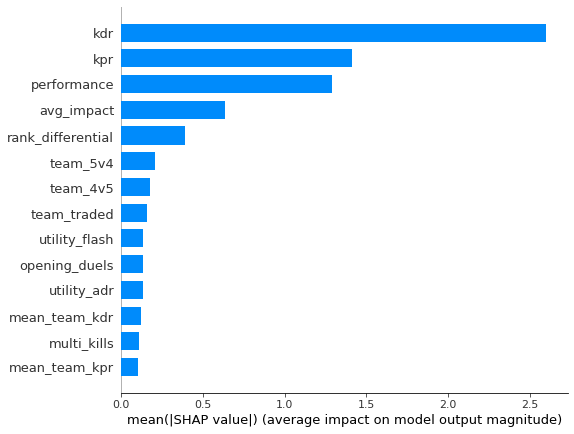

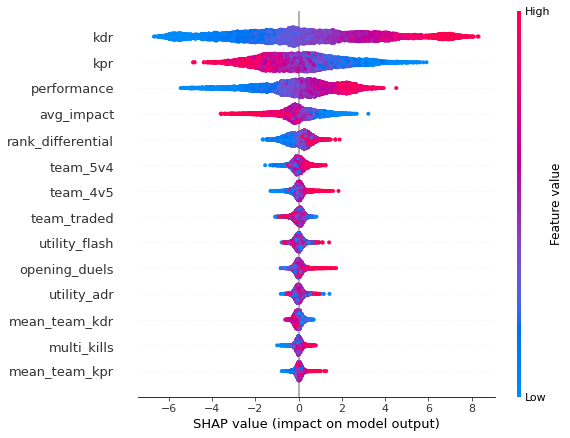

In [229]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values,x_test,plot_type='bar')
shap.summary_plot(shap_values,x_test)

In [186]:
# def get_win_prediction(player, map_, kills, deaths, rank_difference, df, clf):
#     ourSet = [kills, deaths, rank_difference]
#     Al = df.loc[df['player'] == player]
#     Al = Al.loc[df['map'] == map_]
#     Ax = np.array(Al['X'].tolist()).mean(axis=0)
    
#     X = list(np.subtract(ourSet, Ax))
#     return "WIN" if clf.predict([X])[0] == 1 else "LOSS"

In [230]:
def predict(model, target):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values[1], target, matplotlib=True)

def predict0(model, target):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values[0], target, matplotlib=True)

# The shap_values[0] are explanations with respect to the negative class, while shap_values[1] are explanations with respect to the positive class. 
# If your model predicts a probability, p, for the positive class, the negative class' predicted probability will be 1-p.

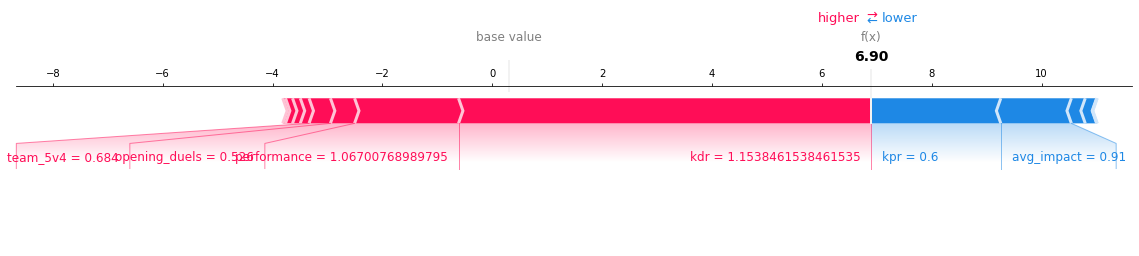

In [231]:
target = x_test.iloc[200,:].astype(float)
predict(model, target)

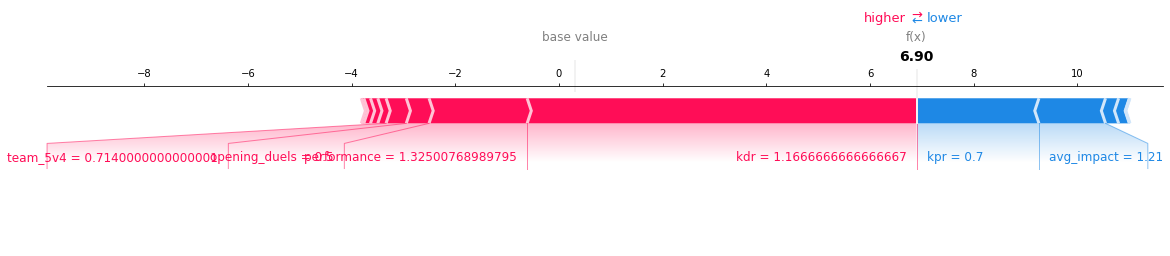

In [234]:
target = x_test.iloc[1559,:].astype(float)
predict(model, target)

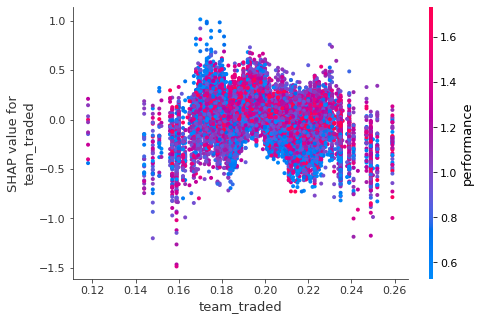

In [200]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.dependence_plot('team_traded', shap_values, X)

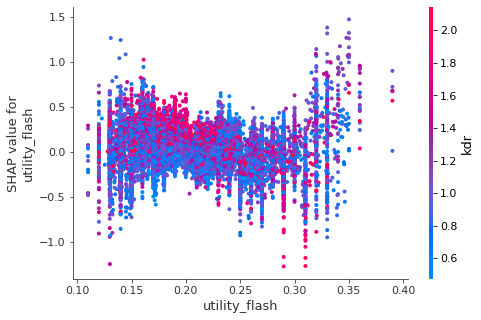

In [201]:
shap.dependence_plot('utility_flash', shap_values, X)

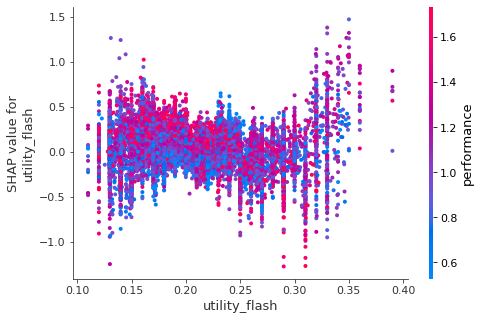

In [204]:
shap.dependence_plot('utility_flash', shap_values, X, interaction_index="performance")

In [238]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value,shap_values[100:150,],x_test.iloc[100:150,])

In [61]:
import numpy as np
np.set_printoptions(threshold=np.inf)

In [232]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(x_test.iloc[1000,:])


avg_impact            1.340000
opening_duels         0.440000
multi_kills           0.850000
team_5v4              0.813000
team_4v5              0.310000
team_traded           0.220000
utility_adr          15.700000
utility_flash         0.160000
kdr                   1.058824
kpr                   0.720000
performance           1.390758
rank_differential    20.000000
mean_team_kdr         1.199882
mean_team_kpr         0.708347
Name: 1559, dtype: float64


In [77]:
y_test.iloc[42,]

0

In [133]:
df['target'].loc[19091]

1

In [233]:
df.loc[1559]

player                          s1mple
date                        2017-05-07
team                     Natus Vincere
team_rounds                         16
opposing_team           Space Soldiers
opposing_team_rounds                 9
map                                trn
kills                               18
deaths                              17
differential                         1
rating                            1.06
avg_impact                        1.34
p_rounds_won                     0.531
opening_duels                     0.44
multi_kills                       0.85
team_5v4                         0.813
team_4v5                          0.31
team_traded                       0.22
utility_adr                       15.7
utility_flash                     0.16
target                               1
opposing_team_rank                  26
team_rank                            6
kdr                           1.058824
kpr                               0.72
n_impact                 